For a full explanation of the code, visit http://ataspinar.com/2017/12/04/using-convolutional-neural-networks-to-detect-features-in-sattelite-images/

In [1]:
import sys
sys.path.insert(0,'..')

import os
import json
import pickle
import requests
import shutil
import random
import numpy as np

from collections import defaultdict
from scipy import ndimage
from datetime import date
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt

#We are using owslib to download images from a WMS Service
#install with 'pip install owslib'

import owslib

from owslib.wms import WebMapService

#pyshp is necessary for loading and saving shapefiles
#install with 'pip install pyshp'
import shapefile

# Install opencv with 'pip install opencv-python'
import cv2

from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
x_min = 90000
y_min = 427000
dx, dy = 200, 200
no_tiles_x = 100
no_tiles_y = 100
total_no_tiles = no_tiles_x * no_tiles_y

x_max = x_min + no_tiles_x * dx
y_max = y_min + no_tiles_y * dy
bounding_box = [x_min, y_min, x_max, y_max]

TILE_FOLDER = "./datasets/image_tiles_200/"
URL_TILES = "https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?request=GetCapabilities"

URL_SHP = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shp'
URL_PRF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.prj'
URL_DBF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.dbf'
URL_SHX = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shx'

URLS_SHAPEFILES = [URL_SHP, URL_PRF, URL_DBF, URL_SHX]

DATA_FOLDER = "./data/nwb_wegvakken/"

json_filename = DATA_FOLDER + '2017_09_wegvakken.json'

# 1. Downloading the image tiles

In [ ]:
#Skip if you already have the image tiles. Will take ~ 2hours.
wms = WebMapService(URL_TILES, version='1.1.1')

if not os.path.exists(TILE_FOLDER):
    os.makedirs(TILE_FOLDER)

for ii in range(0,25):
    print(ii)
    for jj in range(0,no_tiles_y):
        ll_x_ = x_min + ii*dx
        ll_y_ = y_min + jj*dy
        bbox = (ll_x_, ll_y_, ll_x_ + dx, ll_y_ + dy) 
        img = wms.getmap(layers=['Actueel_ortho25'], srs='EPSG:28992', bbox=bbox, size=(256, 256), format='image/jpeg', transparent=True)
        filename = "{}{}_{}_{}_{}.jpg".format(TILE_FOLDER, bbox[0], bbox[1], bbox[2], bbox[3])
        out = open(filename, 'wb')
        out.write(img.read())
        out.close()


## 1b. Downloading the shapefiles

In [ ]:
#Skip if you already have the shapefiles. Will take ~ 1hour.
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

for url in URLS_SHAPEFILES:
    filename = url.split('/')[-1]
    print("Downloading file {}".format(filename))
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(DATA_FOLDER + filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)     

# 2. Loading shapefile and converting to (GEO)Json

In [ ]:
# Skip if conversion already done and "json_filename" already saved
def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime, date)):
        serial = obj.isoformat()
        return serial
    if isinstance(obj, bytes):
        return {'__class__': 'bytes',
                '__value__': list(obj)}
    raise TypeError ("Type %s not serializable" % type(obj))

reader = shapefile.Reader(DATA_FOLDER + 'Wegvakken.shp')
fields = reader.fields[1:]
field_names = [field[0] for field in fields]

buffer = []
for sr in reader.shapeRecords()[:500000]:
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 


json_file = open(json_filename, "w")
json_file.write(json.dumps({"type": "FeatureCollection", "features": buffer}, indent=2, default=json_serial) + "\n")
json_file.close()

# 3. Declaring some variables and methods

In [3]:
dict_roadtype = {
    "G": 'Gemeente',
    "R": 'Rijk',
    "P": 'Provincie',
    "W": 'Waterschap',
    'T': 'Andere wegbeheerder',
    '' : 'leeg'
}

dict_roadtype_to_color = {
    "G": 'red',
    "R": 'blue',
    "P": 'green',
    "W": 'magenta',
    'T': 'yellow',
    '' : 'leeg'
}

FEATURES_KEY = 'features'
PROPERTIES_KEY = 'properties'
GEOMETRY_KEY = 'geometry'
COORDINATES_KEY = 'coordinates'
WEGSOORT_KEY = 'WEGBEHSRT'

MINIMUM_NO_POINTS_PER_TILE = 4
POINTS_PER_METER = 10 # Changed by David from 0.1

INPUT_FOLDER_TILES = './datasets/image_tiles_200/'

In [4]:
def add_to_dict(d1, d2, coordinates, rtype):
    coordinate_ll_x = int((coordinates[0] // dx)*dx)
    coordinate_ll_y = int((coordinates[1] // dy)*dy)
    coordinate_ur_x = int((coordinates[0] // dx)*dx + dx)
    coordinate_ur_y = int((coordinates[1] // dy)*dy + dy)
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)
    
    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)
    d2[rtype].add(tile)

def coord_is_in_bb(coord, bb):
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return coord[0] > x_min and coord[0] < x_max and coord[1] > y_min and coord[1] < y_max

def retrieve_roadtype(elem):
    return elem[PROPERTIES_KEY][WEGSOORT_KEY]
   
def retrieve_coordinates(elem):
    return elem[GEOMETRY_KEY][COORDINATES_KEY]

def eucledian_distance(p1, p2):
    diff = np.array(p2)-np.array(p1)
    return np.linalg.norm(diff)

def calculate_intermediate_points(p1, p2, no_points):
    dx = (p2[0] - p1[0]) / (no_points + 1)
    dy = (p2[1] - p1[1]) / (no_points + 1)
    return [[p1[0] + i * dx, p1[1] +  i * dy] for i in range(1, no_points+1)]



# 4. Map contents of shapefile to the tiles

In [5]:
filename_wegvakken = json_filename
dict_wegvakken = json.load(open(filename_wegvakken))[FEATURES_KEY]

In [6]:
d_tile_contents = defaultdict(list)
d_roadtype_tiles = defaultdict(set)
    
for elem in dict_wegvakken:
    coordinates = retrieve_coordinates(elem)
    rtype = retrieve_roadtype(elem)
    coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, bounding_box)]
    if len(coordinates_in_bb)==1:
        coord = coordinates_in_bb[0]
        add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
    if len(coordinates_in_bb)>1:
        add_to_dict(d_tile_contents, d_roadtype_tiles, coordinates_in_bb[0], rtype)
        for ii in range(1,len(coordinates_in_bb)):
            previous_coord = coordinates_in_bb[ii-1]
            coord = coordinates_in_bb[ii]
            add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
            
            dist = eucledian_distance(previous_coord, coord)
            no_intermediate_points = int(dist*POINTS_PER_METER)           
            intermediate_coordinates = calculate_intermediate_points(previous_coord, coord, no_intermediate_points)
            for intermediate_coord in intermediate_coordinates:
                add_to_dict(d_tile_contents, d_roadtype_tiles, intermediate_coord, rtype)


# Added by David:
# 4a. Create dictionary of road-pixel matrices

In [7]:
# Initialize dictionary
d_road_pixels = {}

# Loop through all image tiles
for ii in range(0,no_tiles_x):
    for jj in range(0,no_tiles_y):
        ll_x = x_min + ii*dx
        ll_y = y_min + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile   
        # Extract list of road coordinates in tile
        tile_contents = d_tile_contents[tile]

        # Find pixel elements corresponding to roads
        # Fill in matrix of values
        pixel_mat = np.zeros((256,256))
        for elem in tile_contents:
            x = int(elem[1]*255)
            y = int((1-elem[2])*255)
            pixel_mat[y,x] = 1
        d_road_pixels[tile] = pixel_mat
        
        #plt.spy(pixel_mat)
        #plt.show()

# 4b. Visualize results

In [ ]:
x0 = 95000
y0 = 430000

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile        
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = plt.imread(filename).astype(int)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

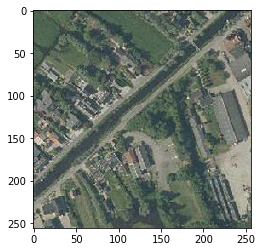

(256, 256, 3)
<class 'numpy.ndarray'>


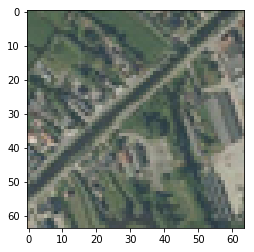

<class 'PIL.Image.Image'>


In [8]:
# DK checks
image = "109800_444000_110000_444200.jpg"
filename = INPUT_FOLDER_TILES + image
image_view = plt.imread(filename).astype(int)
plt.imshow(image_view)
plt.show()
print(image_view.shape)
print(type(image_view))
img = Image.open(filename)
img = img.resize((64,64), Image.ANTIALIAS)
#image_view.resize((64,64), Image.ANTIALIAS)
plt.imshow(img)
plt.show()
print(type(img))

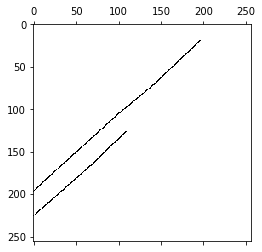

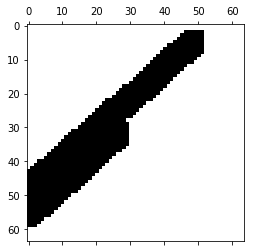

<class 'numpy.ndarray'>


In [9]:
image = "109800_444000_110000_444200.jpg"
test_matrix = d_road_pixels[image]
plt.spy(test_matrix)
plt.show()
test_resize = np.copy(test_matrix)
test_img = Image.fromarray(test_resize)
test_img = np.asarray(test_img.resize((64,64), Image.ANTIALIAS))
plt.spy(test_img)
plt.show()
print(type(test_img))

error: /tmp/build/80754af9/opencv_1525313247723/work/modules/imgproc/src/color.cpp:11010: error: (-215) depth == 0 || depth == 2 || depth == 5 in function cvtColor


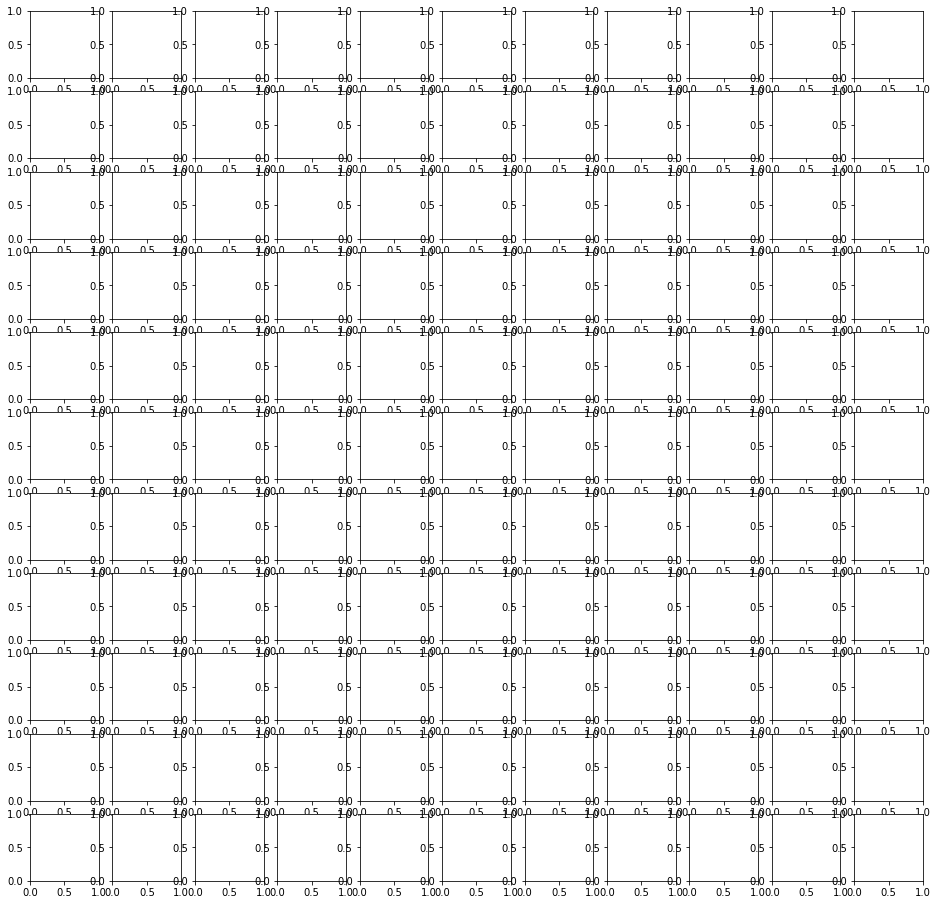

In [10]:
x0 = 95400
y0 = 432000
POINTS_PER_METER = 0

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = plt.imread(filename).astype(int)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# 4c. Some statistics about the dataset

In [11]:
for rtype in d_roadtype_tiles.keys():
    roadtype = dict_roadtype[rtype]
    no_tiles = len(d_roadtype_tiles[rtype])
    print("Of roadtype {} ({}) there are {} tiles.".format(rtype, roadtype, no_tiles))

Of roadtype G (Gemeente) there are 4963 tiles.
Of roadtype W (Waterschap) there are 915 tiles.
Of roadtype P (Provincie) there are 48 tiles.
Of roadtype T (Andere wegbeheerder) there are 1 tiles.


# 5. Prepare dataset for CNN

In [12]:
def randomize(dataset, labels1):
    permutation = np.random.permutation(dataset.shape[0])
    print(permutation.shape)
    print(dataset.shape)
    print(labels1.shape)
    randomized_dataset = dataset[permutation, :, :, :]
    randomized_labels1 = labels1[permutation, :]
    return randomized_dataset, randomized_labels1

#  5a. Resize images and labels to 64*64

Counter = 0
Road pixel percentage: 0.34130859375
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


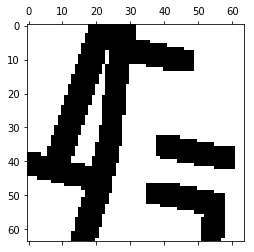

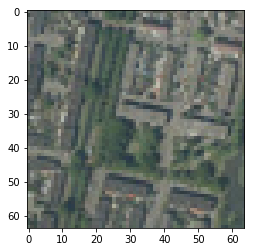

0 images have been loaded.
Counter = 400
Road pixel percentage: 0.4130859375
[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


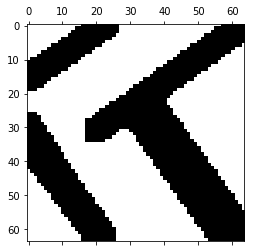

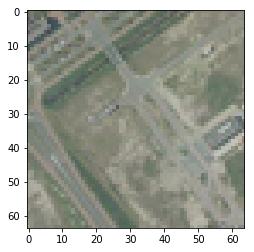

Counter = 800
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


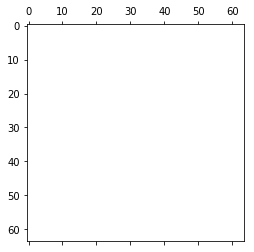

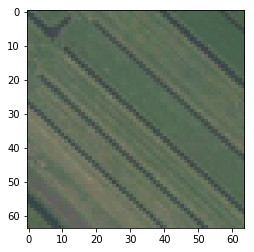

1000 images have been loaded.
Counter = 1200
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


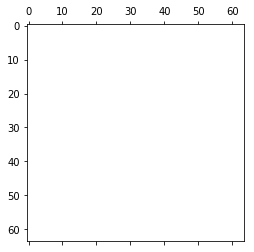

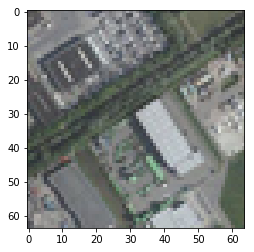

Counter = 1600
Road pixel percentage: 0.197265625
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


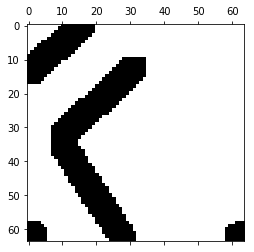

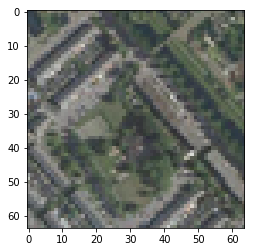

Counter = 2000
Road pixel percentage: 0.1650390625
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


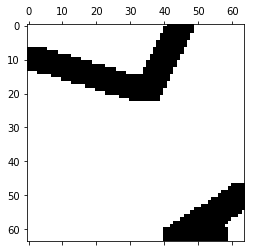

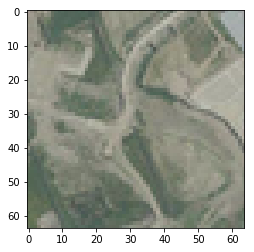

2000 images have been loaded.
Counter = 2400
Road pixel percentage: 0.054443359375
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


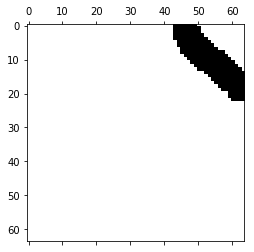

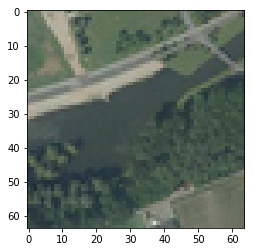

Counter = 2800
Road pixel percentage: 0.158935546875
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


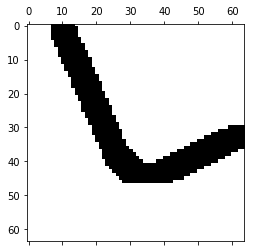

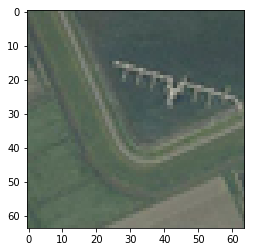

3000 images have been loaded.
Counter = 3200
Road pixel percentage: 0.12060546875
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


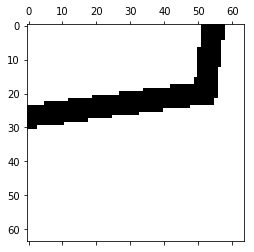

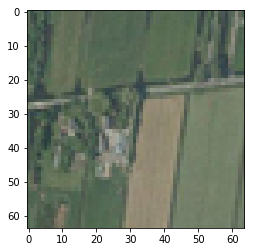

Counter = 3600
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


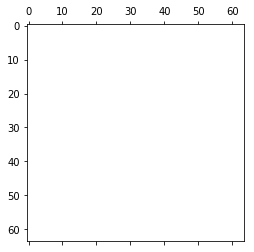

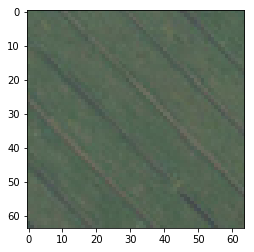

Counter = 4000
Road pixel percentage: 0.11669921875
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


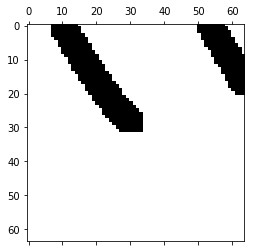

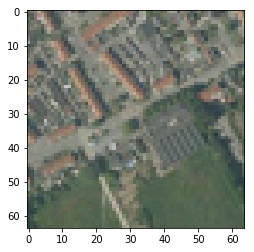

4000 images have been loaded.
Counter = 4400
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


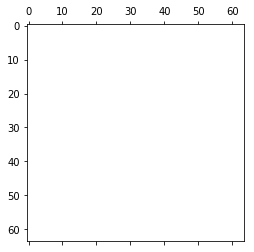

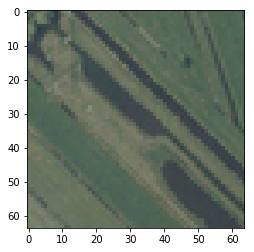

Counter = 4800
Road pixel percentage: 0.089111328125
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


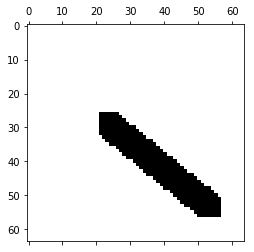

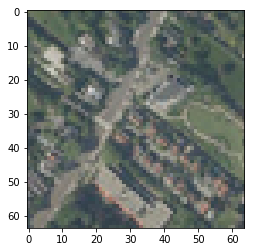

5000 images have been loaded.
Counter = 5200
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


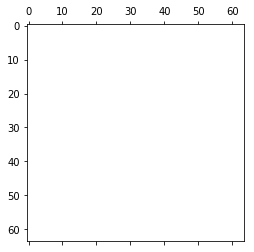

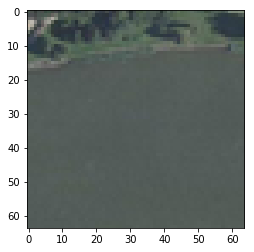

Counter = 5600
Road pixel percentage: 0.0849609375
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


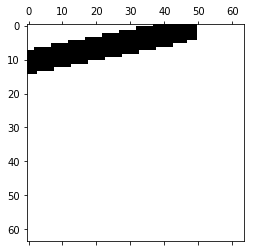

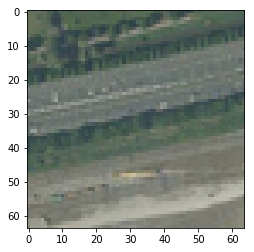

Counter = 6000
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


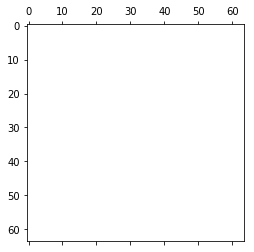

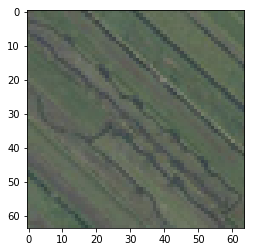

6000 images have been loaded.
Counter = 6400
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


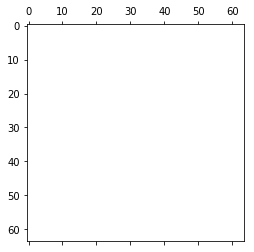

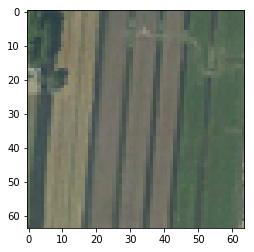

Counter = 6800
Road pixel percentage: 0.10888671875
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


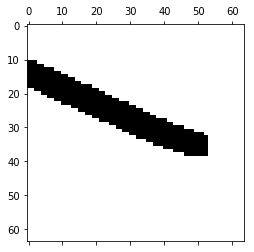

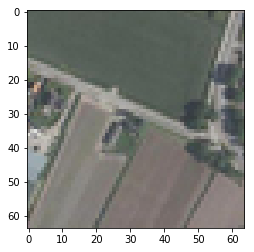

7000 images have been loaded.
Counter = 7200
Road pixel percentage: 0.2099609375
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


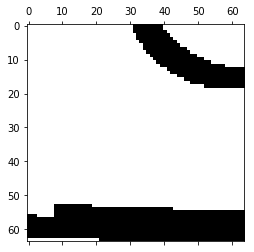

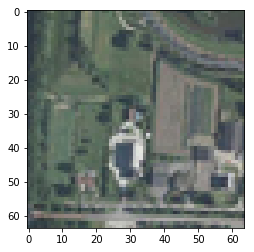

Counter = 7600
Road pixel percentage: 0.424072265625
[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


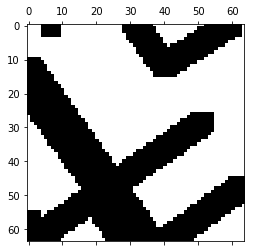

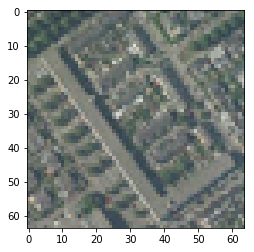

Counter = 8000
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


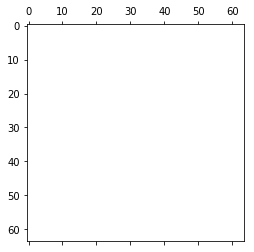

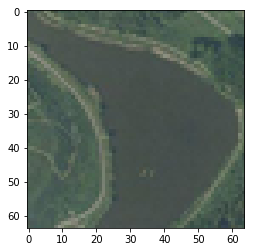

8000 images have been loaded.
Counter = 8400
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


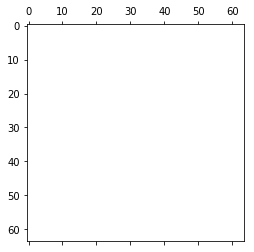

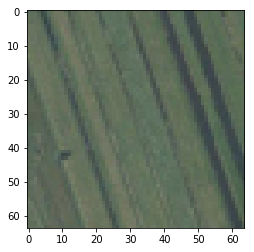

Counter = 8800
Road pixel percentage: 0.288330078125
[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


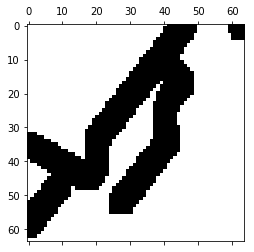

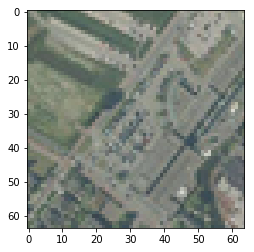

9000 images have been loaded.
Counter = 9200
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


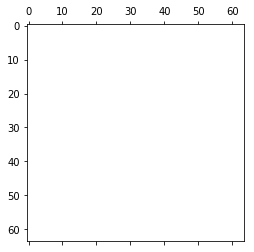

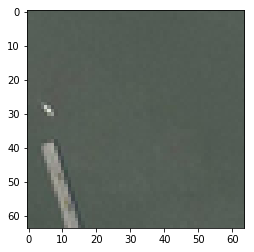

Counter = 9600
Road pixel percentage: 0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


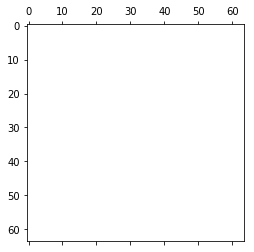

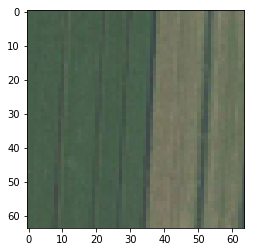

(10000, 64, 64, 3)
(10000, 4096)


In [60]:
image_width = 256
image_height = 256
image_depth = 3
total_no_images = 10000
split_factor = 4

new_image_height = int(image_height/split_factor)
new_image_width = int(image_width/split_factor)
#new_images = split_factor**2
#new_total_images = new_images*total_no_images

image_files = os.listdir(INPUT_FOLDER_TILES)

# Initialize new datasets for cropped images
labels_filename = []
dataset = np.ndarray(shape=(total_no_images, new_image_width, \
                            new_image_height, image_depth), dtype=int)
labels_roadpixel = np.zeros((total_no_images, new_image_width * new_image_height))

# Loop through each image and add to dataset
for counter, image in enumerate(image_files):
    filename = INPUT_FOLDER_TILES + image
    if image in list(d_tile_contents.keys()):
        tile_contents = d_tile_contents[image]
        label_roadpixel = np.asarray(Image.fromarray(np.copy(d_road_pixels[image])).resize((64,64), Image.ANTIALIAS))
        label_roadpixel_binary = np.where(label_roadpixel!=0,1,0)
        labels_roadpixel[counter] = label_roadpixel_binary.flatten()
        image_data = np.asarray(Image.open(filename).resize((64,64), Image.ANTIALIAS))
        dataset[counter, :, :] = image_data
        if (counter % 400 ==0):
            print("Counter = " + str(counter))
            plt.spy(labels_roadpixel[counter].reshape(64,64))
            road_pixel_percent = sum(labels_roadpixel[counter])/4096
            print("Road pixel percentage: "+ str(road_pixel_percent))
            print(labels_roadpixel[counter].reshape(64,64))
            plt.show()
            plt.imshow(image_data)
            plt.show()
    
    if counter % 1000 == 0:
        print("{} images have been loaded.".format(counter))
        
print(dataset.shape)
print(labels_roadpixel.shape)

In [61]:
#labels_filename = np.array(labels_filename)
print("Randomizing dataset...")
dataset, labels_roadpixels = randomize(dataset, labels_roadpixel)

Randomizing dataset...
(10000,)
(10000, 64, 64, 3)
(10000, 4096)


In [62]:
# Split into train/validation/test sets
# For training set, subset on images with roads only
start_train_dataset = 0
start_valid_dataset = 8000
start_test_dataset = 9000
total_no_images = 10000

sum_labels = np.sum(labels_roadpixels[0:start_valid_dataset,:], axis=1)
idx_train = np.where(sum_labels > 0)[0]

output_pickle_file = './data/sattelite_dataset_pixel_resize.pickle'

f = open(output_pickle_file, 'wb')
save = {
'train_dataset': dataset[idx_train,:,:,:],
'train_labels_roadpixels': labels_roadpixels[idx_train,:],
'valid_dataset': dataset[start_valid_dataset:start_test_dataset,:,:,:],
'valid_labels_roadpixels': labels_roadpixels[start_valid_dataset:start_test_dataset,:],
'test_dataset': dataset[start_test_dataset:total_no_images,:,:,:],
'test_labels_roadpixels': labels_roadpixels[start_test_dataset:total_no_images,:],
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

print("\nsaved dataset to {}".format(output_pickle_file))


saved dataset to ./data/sattelite_dataset_pixel_resize.pickle


# 6. The Convolutional neural network part (Using ResNet-50 for pixel level classification)

In [83]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model
from keras import optimizers
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform, glorot_normal
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [17]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [46]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s, s), padding = "valid", name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = "same", name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = "valid", name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = "valid", name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [64]:
def ResNet50(input_shape = (64, 64, 3)):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = "avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(4096, activation='sigmoid', name='fc', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [145]:
def DenseNet2(input_shape = (64, 64, 3)):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X = Flatten()(X_input)
    X = Dense(4096, activation='relu', name='fc1', kernel_initializer = glorot_normal(seed=0), bias_initializer=glorot_normal(seed=0))(X)
    X = Dropout(0.5)(X)
    X = Dense(4096, activation='sigmoid', name='fc2', kernel_initializer = glorot_normal(seed=0), bias_initializer=glorot_normal(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='DenseNet2')

    return model

In [109]:
# Define custom binary loss function with weights
def weighted_binary_crossentropy(y_true, y_pred) :
    weight = 0.63
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred) * (1 - weight))   
    return K.mean(logloss, axis=-1)

In [24]:

def focal_loss(target, output, gamma=2):
    output /= K.sum(output, axis=-1, keepdims=True)
    eps = K.epsilon()
    output = K.clip(output, eps, 1. - eps)
    return -K.sum(K.pow(1. - output, gamma) * target * K.log(output),
                  axis=-1)

In [146]:
model = DenseNet2(input_shape = (64, 64, 3))
sgd = optimizers.SGD(lr=0.1, clipvalue=0.5)
model.compile(optimizer='adam',
            loss = 'binary_crossentropy',
              metrics=['accuracy'])

# Skip this section if using augmented dataset

In [129]:
pickle_file = './data/sattelite_dataset_pixel_resize.pickle'
f = open(pickle_file, 'rb')
save = pickle.load(f)

train_dataset = save['train_dataset'].astype(dtype = int)
train_labels = save['train_labels_roadpixels'].astype(dtype = int)
valid_dataset = save['valid_dataset'].astype(dtype = int)
valid_labels = save['valid_labels_roadpixels'].astype(dtype = int)
test_dataset = save['test_dataset'].astype(dtype = int)
test_labels = save['test_labels_roadpixels'].astype(dtype = int)

f.close()

In [130]:
# Normalize image vectors
# For training set, subset on images with roads only
X_train = train_dataset/255.
X_valid = valid_dataset/255.
X_test = test_dataset/255.
Y_train = train_labels
Y_valid = valid_labels
Y_test = test_labels
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(train_labels.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(test_labels.shape))

number of training examples = 4562
number of test examples = 1000
X_train shape: (4562, 64, 64, 3)
Y_train shape: (4562, 4096)
X_test shape: (1000, 64, 64, 3)
Y_test shape: (1000, 4096)


In [50]:
# Load dataset with resized images
pickle_file = './data/sattelite_dataset_pixel_resize.pickle'
f = open(pickle_file, 'rb')
save = pickle.load(f)

X_train_r = save['train_dataset']
Y_train = save['train_labels_roadpixels'].astype(dtype = int)
X_valid_r = save['valid_dataset']
Y_valid = save['valid_labels_roadpixels'].astype(dtype = int)
X_test_r = save['test_dataset']
Y_test = save['test_labels_roadpixels'].astype(dtype = int)

f.close()

In [ ]:
# Normalize image vectors
# For training set, subset on images with roads only
X_train = X_train_r/255.
X_valid = X_valid_r/255.
X_test = X_test_r/255.

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

In [ ]:
# David--test
for i in range(2):
    #print(X_train[i,:])
    plt.imshow(X_train[i,:])
    plt.show()
    #print(Y_train[i,:].reshape(64,64))
    plt.spy(Y_train[i,:].reshape(64,64))
    plt.show()

In [ ]:
model_filepath = './data/resnet50_road_pixels.h5'
model = load_model(model_filepath)

In [135]:
tot_road_pixels = sum(Y_train[:,:].flatten())
tot_pixels = Y_train.shape[0] * Y_train.shape[1]
print(1 - tot_road_pixels/tot_pixels)


0.8221415745903661


In [147]:
# Train model--overfit to 10 examples
model.fit(X_train[0:100], Y_train[0:100], validation_data=(X_valid[0:30], Y_valid[0:30]),batch_size = 32, epochs = 20)

Train on 100 samples, validate on 30 samples
Epoch 1/20
100/100 [==============================] - 9s 93ms/step - loss: 0.6876 - acc: 0.6777 - val_loss: 0.5802 - val_acc: 0.7443
Epoch 2/20
100/100 [==============================] - 3s 29ms/step - loss: 0.5651 - acc: 0.7471 - val_loss: 0.3962 - val_acc: 0.8769
Epoch 3/20
100/100 [==============================] - 3s 30ms/step - loss: 0.5074 - acc: 0.8099 - val_loss: 0.4142 - val_acc: 0.8845
Epoch 4/20
100/100 [==============================] - 3s 29ms/step - loss: 0.4939 - acc: 0.8163 - val_loss: 0.3795 - val_acc: 0.8919
Epoch 5/20
100/100 [==============================] - 3s 30ms/step - loss: 0.4880 - acc: 0.8229 - val_loss: 0.3824 - val_acc: 0.8953
Epoch 6/20
100/100 [==============================] - 3s 30ms/step - loss: 0.4887 - acc: 0.8263 - val_loss: 0.4059 - val_acc: 0.8940
Epoch 7/20
100/100 [==============================] - 3s 29ms/step - loss: 0.4870 - acc: 0.8237 - val_loss: 0.3670 - val_acc: 0.8975
Epoch 8/20
100/100 [====

In [ ]:
# Train model
#model.fit(X_train, Y_train, epochs = 1, batch_size = 512)

In [ ]:
#model.save(model_filepath)

In [ ]:
model.summary()

In [148]:
# Evaluate model on dev set
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 4s 4ms/step
Loss = 0.39133114528656004
Test Accuracy = 0.891287353515625


Image:


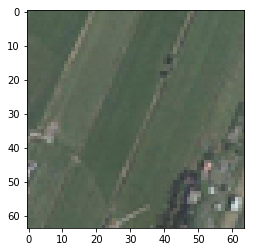

Ground truth labels:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


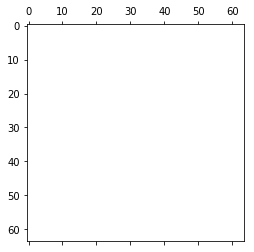

Predicted labels:


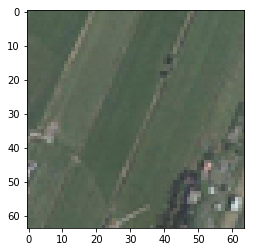

[[0.3195709  0.1883667  0.2990951  ... 0.20836657 0.12134292 0.10685345]
 [0.20938867 0.32807982 0.2894425  ... 0.25376016 0.16208757 0.1355701 ]
 [0.40832034 0.22818197 0.29251298 ... 0.17790537 0.18140317 0.11863752]
 ...
 [0.18247983 0.20642902 0.21948868 ... 0.10907058 0.10961825 0.12587436]
 [0.13107733 0.21339864 0.1721228  ... 0.09125485 0.1908159  0.08300392]
 [0.1580191  0.11882576 0.17594403 ... 0.13020699 0.09662456 0.05355154]]
0.5151336
0.23552716
0.23858467
0.05355154
[[ 1.2953944  -0.80324864  0.96787894 ... -0.48334575 -1.8753102
  -2.1070726 ]
 [-0.466997    1.4314966   0.81348354 ...  0.24273567 -1.2235895
  -1.6477431 ]
 [ 2.7149632  -0.16639362  0.8625965  ... -0.97058016 -0.91463184
  -1.9185836 ]
 ...
 [-0.8974105  -0.51433736 -0.30544496 ... -2.0716093  -2.0628493
  -1.8028288 ]
 [-1.7196059  -0.40285668 -1.0630736  ... -2.356576   -0.7640731
  -2.488552  ]
 [-1.2886659  -1.9155729  -1.0019522  ... -1.7335273  -2.2706864
  -2.9596498 ]]


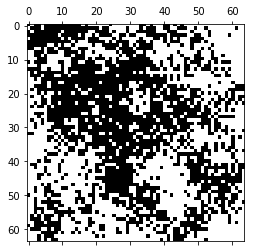

In [154]:
i = 83
image = X_test[i,:]
labels = Y_test[i,:]

print("Image:")
plt.imshow(image)
plt.show()

print("Ground truth labels:")
print(labels.reshape(64,64))
plt.spy(labels.reshape(64,64))
plt.show()

print("Predicted labels:")
img_for_pred = np.zeros((1,64,64,3))
img_for_pred[0,:,:,:] = image
plt.imshow(img_for_pred[0])
plt.show()
pred_probs = model.predict(img_for_pred).reshape(64,64)

print(pred_probs)
print(pred_probs.max())
print(np.median(pred_probs))
print(np.mean(pred_probs))
print(pred_probs.min())
pred_probs = (pred_probs - np.mean(pred_probs))/np.std(pred_probs)

print((pred_probs))
preds = np.where(pred_probs>0,1,0)
plt.spy(preds)
plt.show()